# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## MNIST Dataset


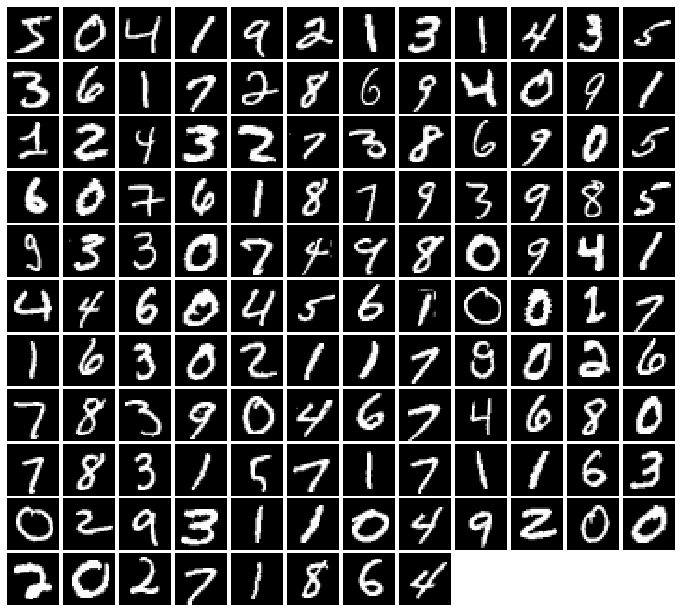

In [4]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Discriminator and Generator


In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [6]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [7]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="files/gan_samples/mnist.jpg" width=500>

EPOCH:  1
Iter: 0, D: 1.033, G:0.6666


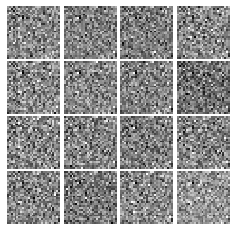


Iter: 250, D: 0.7643, G:0.8618


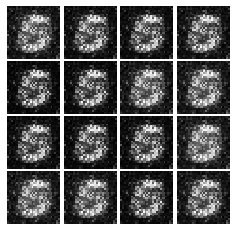


EPOCH:  2
Iter: 500, D: 0.6706, G:1.377


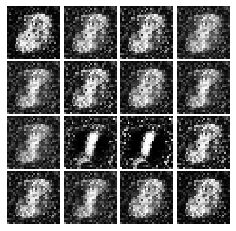


Iter: 750, D: 0.568, G:1.281


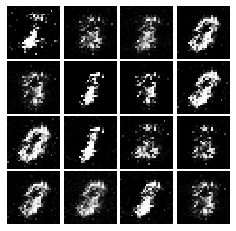


EPOCH:  3
Iter: 1000, D: 0.8245, G:0.8006


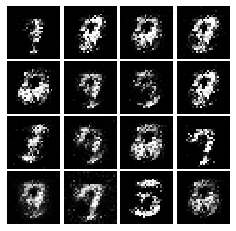


Iter: 1250, D: 0.7651, G:0.812


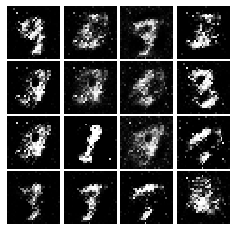


EPOCH:  4
Iter: 1500, D: 0.8272, G:0.8141


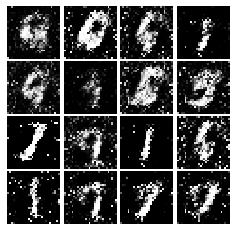


Iter: 1750, D: 0.7839, G:0.7158


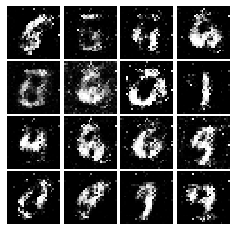


EPOCH:  5
Iter: 2000, D: 0.7498, G:0.7717


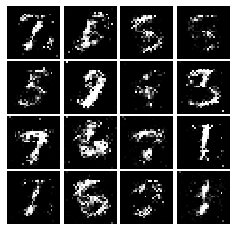


Iter: 2250, D: 0.8612, G:0.7527


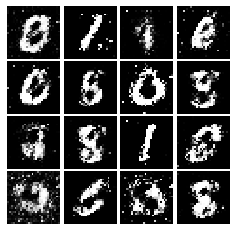


EPOCH:  6
Iter: 2500, D: 0.8821, G:0.772


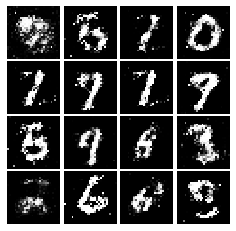


Iter: 2750, D: 0.9208, G:0.4578


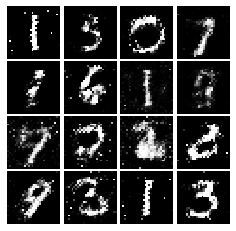


EPOCH:  7
Iter: 3000, D: 0.8164, G:0.5606


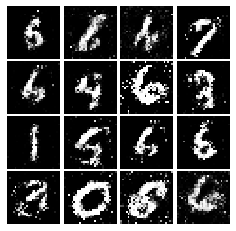


Iter: 3250, D: 0.8273, G:0.5993


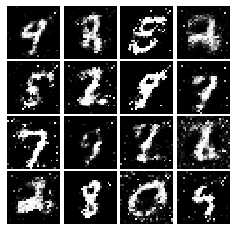


EPOCH:  8
Iter: 3500, D: 0.8822, G:0.5628


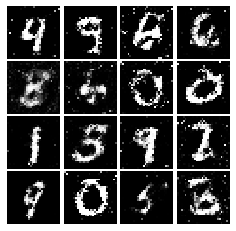


EPOCH:  9
Iter: 3750, D: 0.8441, G:0.7016


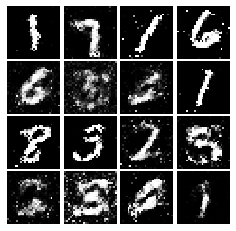


Iter: 4000, D: 0.9158, G:0.5688


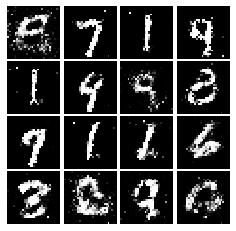


EPOCH:  10
Iter: 4250, D: 0.8607, G:0.5473


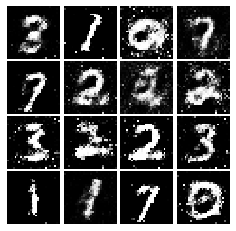


Iter: 4500, D: 0.9463, G:0.4883


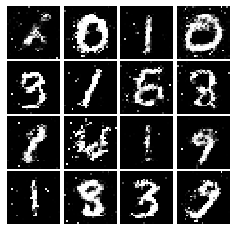

In [8]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

EPOCH:  1
Iter: 0, D: 0.5075, G:0.4662


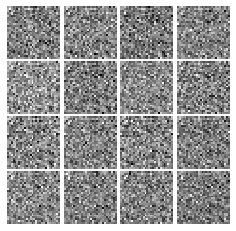


Iter: 250, D: 0.08515, G:0.3206


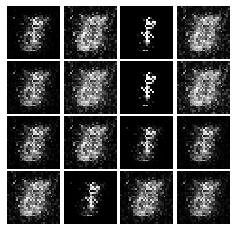


EPOCH:  2
Iter: 500, D: 0.09657, G:0.3281


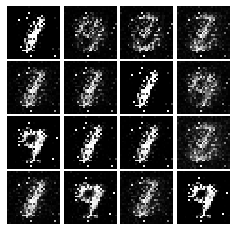


Iter: 750, D: 0.1561, G:0.2197


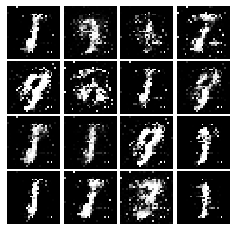


EPOCH:  3
Iter: 1000, D: 0.1124, G:0.3147


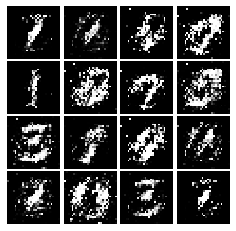


Iter: 1250, D: 0.1625, G:0.3115


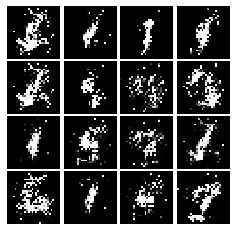


EPOCH:  4
Iter: 1500, D: 0.1537, G:0.6862


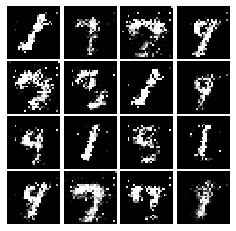


Iter: 1750, D: 0.1817, G:0.2034


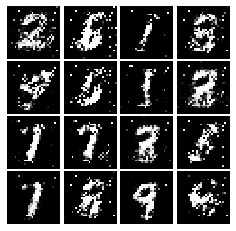


EPOCH:  5
Iter: 2000, D: 0.231, G:0.2309


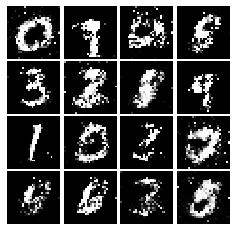


Iter: 2250, D: 0.1886, G:0.2136


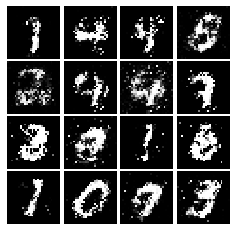


EPOCH:  6
Iter: 2500, D: 0.2397, G:0.1654


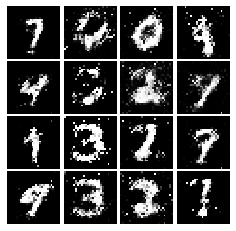


Iter: 2750, D: 0.2146, G:0.1868


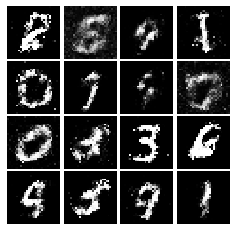


EPOCH:  7
Iter: 3000, D: 0.233, G:0.1476


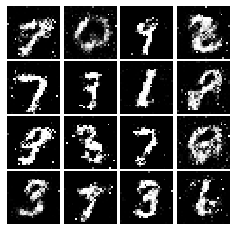


Iter: 3250, D: 0.2165, G:0.1761


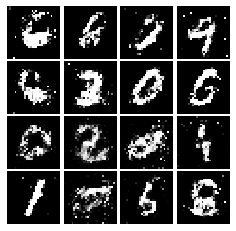


EPOCH:  8
Iter: 3500, D: 0.2174, G:0.1637


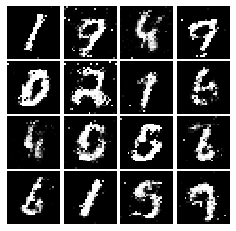


EPOCH:  9
Iter: 3750, D: 0.2303, G:0.1654


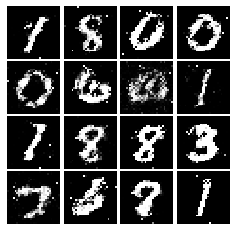


Iter: 4000, D: 0.2536, G:0.147


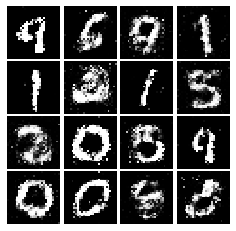


EPOCH:  10
Iter: 4250, D: 0.2088, G:0.1499


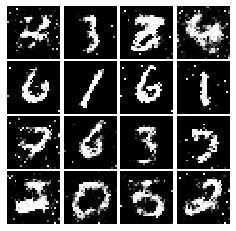


Iter: 4500, D: 0.2271, G:0.1788


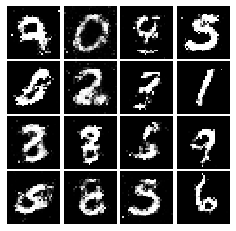

In [9]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)